In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

N_FACE = 70
N_POSE = 25
N_HAND = 21
FOLDER = '/content/drive/My Drive/636/data/json/'
CSV_FOLDER = '/content/drive/My Drive/636/dataset/'

Reshape Data into Segments and Prepare for Keras (part5 data)

In [0]:
dataset = pd.read_csv(CSV_FOLDER + 'dataset_pose_only.csv')

In [4]:
vid = dataset.vid.unique()

from sklearn.model_selection import train_test_split
X_train_vid, X_test_vid= train_test_split(vid, test_size=0.15, random_state=3)
print(X_train_vid.shape, X_test_vid.shape)

X_test_data = dataset.loc[dataset['vid'].isin(X_test_vid)]
X_test_data = X_test_data.reset_index()
X_test_data.drop(X_test_data.columns[[0]], axis=1, inplace=True)

X_train_data = dataset.loc[dataset['vid'].isin(X_train_vid)]
X_train_data = X_train_data.reset_index()
X_train_data.drop(X_train_data.columns[[0]], axis=1, inplace=True)

print(X_test_data.shape[0] / dataset.shape[0])
print(X_test_data.index[X_test_data['label'] == 1].shape[0] / X_test_data.index[X_test_data['label'] == 0].shape[0])

(443,) (79,)
0.14902275184334876
0.9931762794476036


In [5]:
print(X_train_data.shape, X_test_data.shape)

(70055, 53) (12268, 53)


In [0]:
# get number of features
# N_FEATURES = (N_FACE + N_POSE + N_HAND * 2) * 2
N_FEATURES = N_POSE * 2

In [7]:
N_FEATURES

50

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[3:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
y_train = X_train_data['label'].to_numpy()
y_test = X_test_data['label'].to_numpy()

In [0]:
X_train = create_segments(X_train_data, 10)
X_test = create_segments(X_test_data, 10)

In [0]:
# idx = np.random.permutation(y_train.shape[0])
# X_train, y_train = X_train[idx], y_train[idx]

In [0]:
# draw
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'b', label='Training acc', color='red')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss', color='red')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Build model

In [0]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Activation, Dropout, Flatten, Bidirectional, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import History, EarlyStopping, ModelCheckpoint

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = N_FEATURES
# callbacks
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
# callbacks_list = [early_stop, mcp_save]
callbacks_list = [early_stop]
model_path = './drive/My Drive/636/model/'

Model 1

In [0]:
def create_model_1(X_train):
  model = Sequential()

  model.add(Conv1D(32, 3, padding ='same', input_shape=(X_train.shape[1:])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(32, 3, padding ='same'))
  model.add(BatchNormalization())
  
  model.add(Conv1D(64, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(64, 3, padding ='same'))
  model.add(BatchNormalization())
  
  model.add(Conv1D(64, 3, padding ='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(64, 3, padding ='same'))
  model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [26]:
# create model
model_1 = create_model_1(X_train)
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 10, 32)            4832      
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 32)            128       
_________________________________________________________________
activation_4 (Activation)    (None, 10, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 10, 32)            3104      
_________________________________________________________________
batch_normalization_10 (Batc (None, 10, 32)            128       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 10, 64)            6208      
_________________________________________________________________
batch_normalization_11 (Batc (None, 10, 64)           

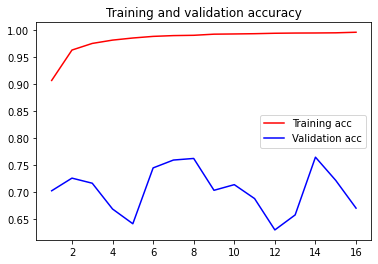

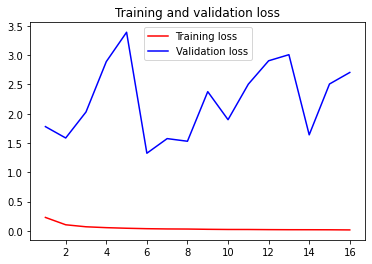

In [27]:
draw(history)

In [0]:
model_1.save(model_path + 'model1_8119.csv')

In [39]:
# create model
model_1 = create_model_1(X_train)
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=64, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 10, 32)            4832      
_________________________________________________________________
batch_normalization_33 (Batc (None, 10, 32)            128       
_________________________________________________________________
activation_16 (Activation)   (None, 10, 32)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 10, 32)            3104      
_________________________________________________________________
batch_normalization_34 (Batc (None, 10, 32)            128       
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 10, 64)            6208      
_________________________________________________________________
batch_normalization_35 (Batc (None, 10, 64)           

In [43]:
# create model
model_1 = create_model_1(X_train)
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 10, 32)            4832      
_________________________________________________________________
batch_normalization_51 (Batc (None, 10, 32)            128       
_________________________________________________________________
activation_25 (Activation)   (None, 10, 32)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 10, 32)            3104      
_________________________________________________________________
batch_normalization_52 (Batc (None, 10, 32)            128       
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 10, 64)            6208      
_________________________________________________________________
batch_normalization_53 (Batc (None, 10, 64)          

In [0]:
X_train_15 = create_segments(X_train_data, 15)
X_test_15 = create_segments(X_test_data, 15)

In [0]:
# hyperparameter
TIME_STEP = 15
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = N_FEATURES
# callbacks
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
# callbacks_list = [early_stop, mcp_save]
callbacks_list = [early_stop]
model_path = './drive/My Drive/636/model/'

In [50]:
# create model
model_1_15 = create_model_1(X_train_15)
history = model_1_15.fit(X_train_15, y_train, epochs=EPOCH, batch_size=64, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1_15.evaluate(X_test_15, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 15, 32)            4832      
_________________________________________________________________
batch_normalization_69 (Batc (None, 15, 32)            128       
_________________________________________________________________
activation_34 (Activation)   (None, 15, 32)            0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
batch_normalization_70 (Batc (None, 15, 32)            128       
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 15, 64)            6208      
_________________________________________________________________
batch_normalization_71 (Batc (None, 15, 64)          

In [0]:
model_1_15.save(model_path + 'model1_15_8603.csv')

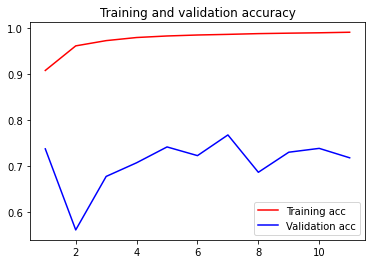

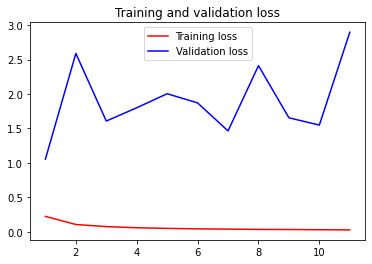

In [52]:
draw(history)

In [0]:
X_train_20 = create_segments(X_train_data, 20)
X_test_20 = create_segments(X_test_data, 20)

In [0]:
# hyperparameter
TIME_STEP = 20
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = N_FEATURES
# callbacks
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
# callbacks_list = [early_stop, mcp_save]
callbacks_list = [early_stop]
model_path = './drive/My Drive/636/model/'

In [32]:
# create model
model_1_20 = create_model_1(X_train_20)
history = model_1_20.fit(X_train_20, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1_20.evaluate(X_test_20, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 20, 32)            4832      
_________________________________________________________________
batch_normalization_21 (Batc (None, 20, 32)            128       
_________________________________________________________________
activation_10 (Activation)   (None, 20, 32)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
batch_normalization_22 (Batc (None, 20, 32)            128       
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 20, 64)            6208      
_________________________________________________________________
batch_normalization_23 (Batc (None, 20, 64)           

In [40]:
# create model
model_1_20 = create_model_1(X_train_20)
history = model_1_20.fit(X_train_20, y_train, epochs=EPOCH, batch_size=64, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1_20.evaluate(X_test_20, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 20, 32)            4832      
_________________________________________________________________
batch_normalization_39 (Batc (None, 20, 32)            128       
_________________________________________________________________
activation_19 (Activation)   (None, 20, 32)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
batch_normalization_40 (Batc (None, 20, 32)            128       
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 20, 64)            6208      
_________________________________________________________________
batch_normalization_41 (Batc (None, 20, 64)          

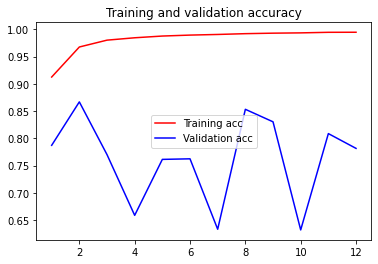

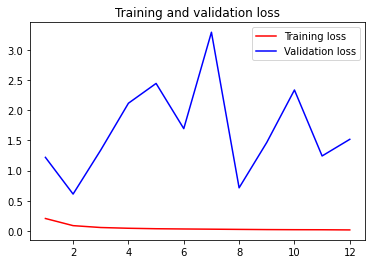

In [33]:
draw(history)

In [0]:
model_1_20.save(model_path + 'model1_20_8633.csv')

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 20, 32)            4832      
_________________________________________________________________
batch_normalization_57 (Batc (None, 20, 32)            128       
_________________________________________________________________
activation_28 (Activation)   (None, 20, 32)            0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
batch_normalization_58 (Batc (None, 20, 32)            128       
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 20, 64)            6208      
_________________________________________________________________
batch_normalization_59 (Batc (None, 20, 64)          

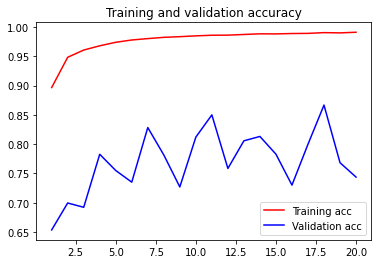

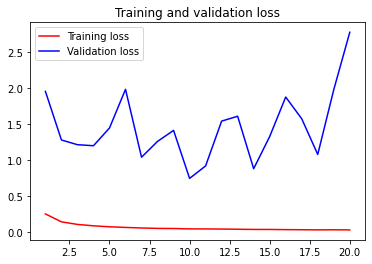

In [44]:
model_1_20 = create_model_1(X_train_20)
history = model_1_20.fit(X_train_20, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1_20.evaluate(X_test_20, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
X_train_30 = create_segments(X_train_data, 30)
X_test_30 = create_segments(X_test_data, 30)

In [0]:
# hyperparameter
TIME_STEP = 30
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = N_FEATURES
# callbacks
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
# callbacks_list = [early_stop, mcp_save]
callbacks_list = [early_stop]
model_path = './drive/My Drive/636/model/'

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 30, 32)            4832      
_________________________________________________________________
batch_normalization_27 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_13 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_28 (Batc (None, 30, 32)            128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 30, 64)            6208      
_________________________________________________________________
batch_normalization_29 (Batc (None, 30, 64)           

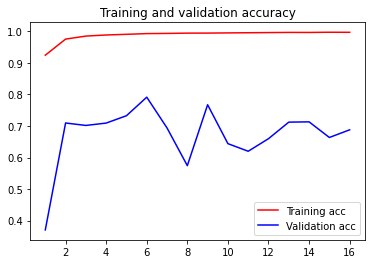

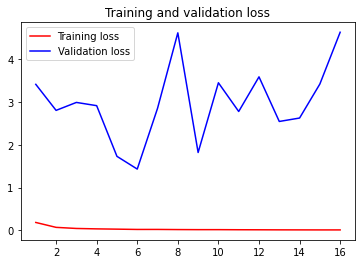

In [38]:
# create model
model_1_30 = create_model_1(X_train_30)
history = model_1_30.fit(X_train_30, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1_30.evaluate(X_test_30, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 30, 32)            4832      
_________________________________________________________________
batch_normalization_45 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_22 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_46 (Batc (None, 30, 32)            128       
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 30, 64)            6208      
_________________________________________________________________
batch_normalization_47 (Batc (None, 30, 64)          

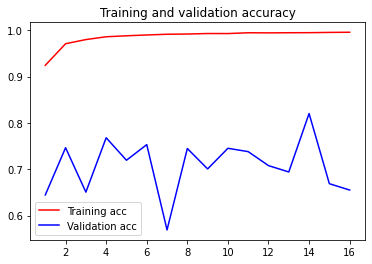

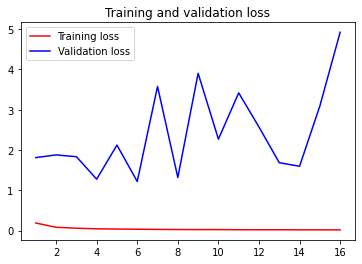

In [41]:
# create model
model_1_30 = create_model_1(X_train_30)
history = model_1_30.fit(X_train_30, y_train, epochs=EPOCH, batch_size=64, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1_30.evaluate(X_test_30, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 30, 32)            4832      
_________________________________________________________________
batch_normalization_63 (Batc (None, 30, 32)            128       
_________________________________________________________________
activation_31 (Activation)   (None, 30, 32)            0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 30, 32)            3104      
_________________________________________________________________
batch_normalization_64 (Batc (None, 30, 32)            128       
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 30, 64)            6208      
_________________________________________________________________
batch_normalization_65 (Batc (None, 30, 64)          

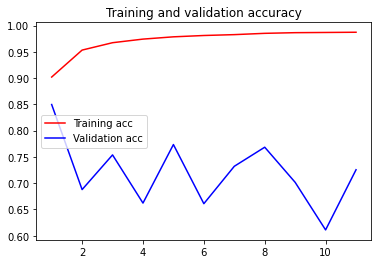

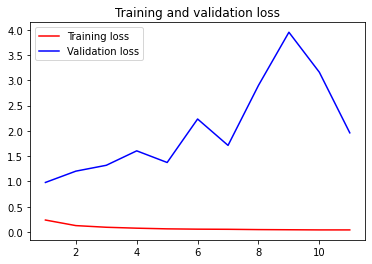

In [45]:
# create model
model_1_30 = create_model_1(X_train_30)
history = model_1_30.fit(X_train_30, y_train, epochs=EPOCH, batch_size=32, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1_30.evaluate(X_test_30, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model_1_30.save(model_path + 'model1_30_8569.csv')